# More detailed interpretation of `FEEMSmix` outputs

This notebook provides detailed interpretations of functions and outputs using the data set from [Schweizer _et al_ 2016](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW).

## Imports

In [1]:
# base
import numpy as np
from importlib import resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs, cov_to_dist
from feems.objective import comp_mats
from feems.viz import draw_FEEMSmix_surface, plot_FEEMSmix_summary
from feems import SpatialGraph, Objective, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

### The documentation for all `FEEMS`/`FEEMSmix` functions can be queried in a notebook environment by typing `?function`

In [2]:
# for example
?draw_FEEMSmix_surface

Signature:
draw_FEEMSmix_surface(
    v,
    ind_results,
    demes=None,
    draw_arrow=True,
    draw_c_surface=False,
    magnifier=1,
    dpi=300,
    figsize=(4, 10),
)
Docstring:
Wrapper function to plot the entire suite of fits from separately fitting each edge
Required:
    v (:obj:`feems.Viz`): Viz object created previously 
    ind_results (:obj:`dict`): output from sp_graph.sequential_fit(...)
    
Optional:
    demes (:obj:`int` or `list`): number or list of edge indices to plot (for any single index, use e.g., [980])
    draw_c_surface (:obj:`Bool`): whether to include a surface of the admixture proportions
    draw_arrow (:obj:`Bool`): whether to draw LREs as arrows
    magnifier (:obj:`float`): scaler on the size of the arrows 
    dpi (:obj:`int`): resolution of figure
    figsize (:obj:`tuple`): (width, height) of matplotlib plot 

Returns: 
    None        
File:      ~/src/feems/feems/viz.py
Type:      function

## Data

Note we have packaged this example dataset in the `FEEMS` package and use the `importlib.resources` package to find the path of those files:

_Note: We were previously using `pkg_resources`, but that package has been deprecated (see [https://setuptools.pypa.io/en/latest/pkg_resources.html](https://setuptools.pypa.io/en/latest/pkg_resources.html))_

In [3]:
data_path = str(resources.files('feems') / 'data')

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 89.86it/s]


n_samples=111, n_snps=17729


## Setup the `SpatialGraph` object

In [4]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
CPU times: user 47.2 s, sys: 1.46 s, total: 48.6 s
Wall time: 54.3 s


In [5]:
projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)

## Fit `FEEMS` (fixed variance across all nodes, default in _v1.0_)

Next we fit a the `FEEMS` model where we allow a weight to be estimated for every edge, which is encoded in a large adjacency matrix $\mathbf{W}$, while encouraging nearby edges to be smooth. We initialize at the fit from the null model and fix the estimate of the residual variance for the more complex optimization:

In [6]:
%%time
sp_graph.fit(lamb = 2.0, optimize_q=None)

CPU times: user 22.8 s, sys: 771 ms, total: 23.5 s
Wall time: 6.38 s


Now we can visualize the weighted graph:

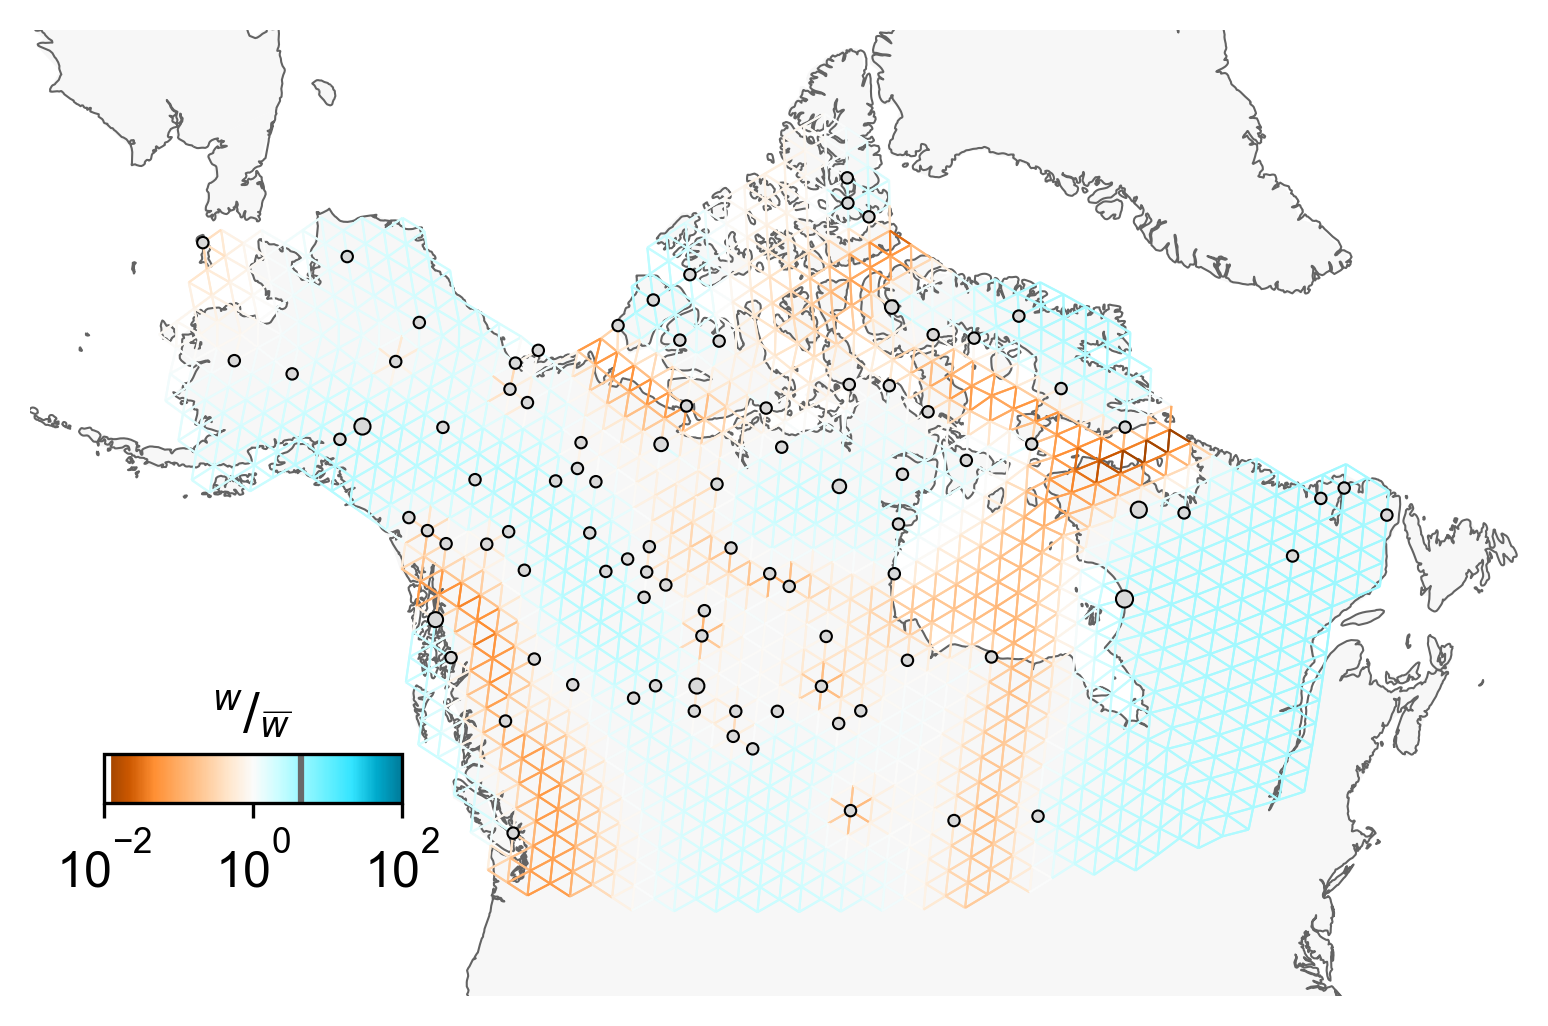

In [7]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

We can also visualize the fit of the model to the observed pairwise genetic distances from the genotype matrix. This is a way of diagnosing model fit. 

Text(0.5, 1.0, '$\\tt{FEEMS}$ fit with fixed node-specific variance')

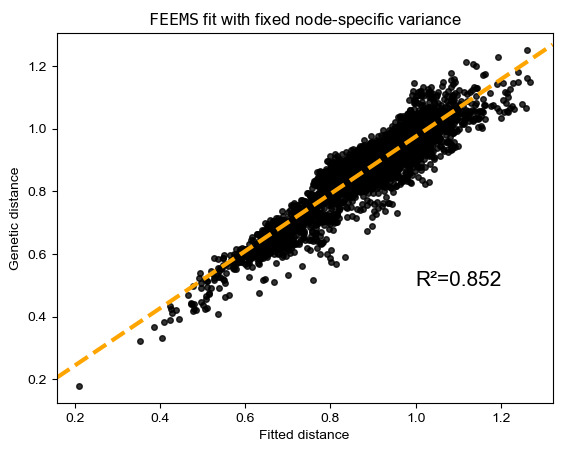

In [8]:
# creating an obj 
obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# computing distances matrice for fit (expected) vs empirical (observed) 
fit_cov, _, emp_cov = comp_mats(obj)
# subsetting matrices to arrays 
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]

# fitting a linear model to the observed distances
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params

plt.figure(dpi=100)
plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4)
plt.axline((0.5,0.5*betahat+muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.text(1, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15)
plt.xlabel('Fitted distance'); plt.ylabel('Genetic distance')
plt.title(r"$\tt{FEEMS}$ fit with fixed node-specific variance")

### Visualize deme-specific variance parameter (similar to heterozygosity)

However, in _v2.0_ we also allow `FEEMS` to fit deme-specific variances so this is the recommended approach. This deme-specific variance parameter is proportional to heterozygosity (and effective population size) as a result of this new mode of fitting. We can visualize this parameter across the grid to observe trends in this value. _Note:_ `FEEMS` only estimates values at sampled nodes in the grid (marked with dark grey outlines) and interpolates the values at unsampled nodes using a Kriging approach with an exponential variogram. 

CPU times: user 1min 21s, sys: 2.54 s, total: 1min 23s
Wall time: 21.9 s


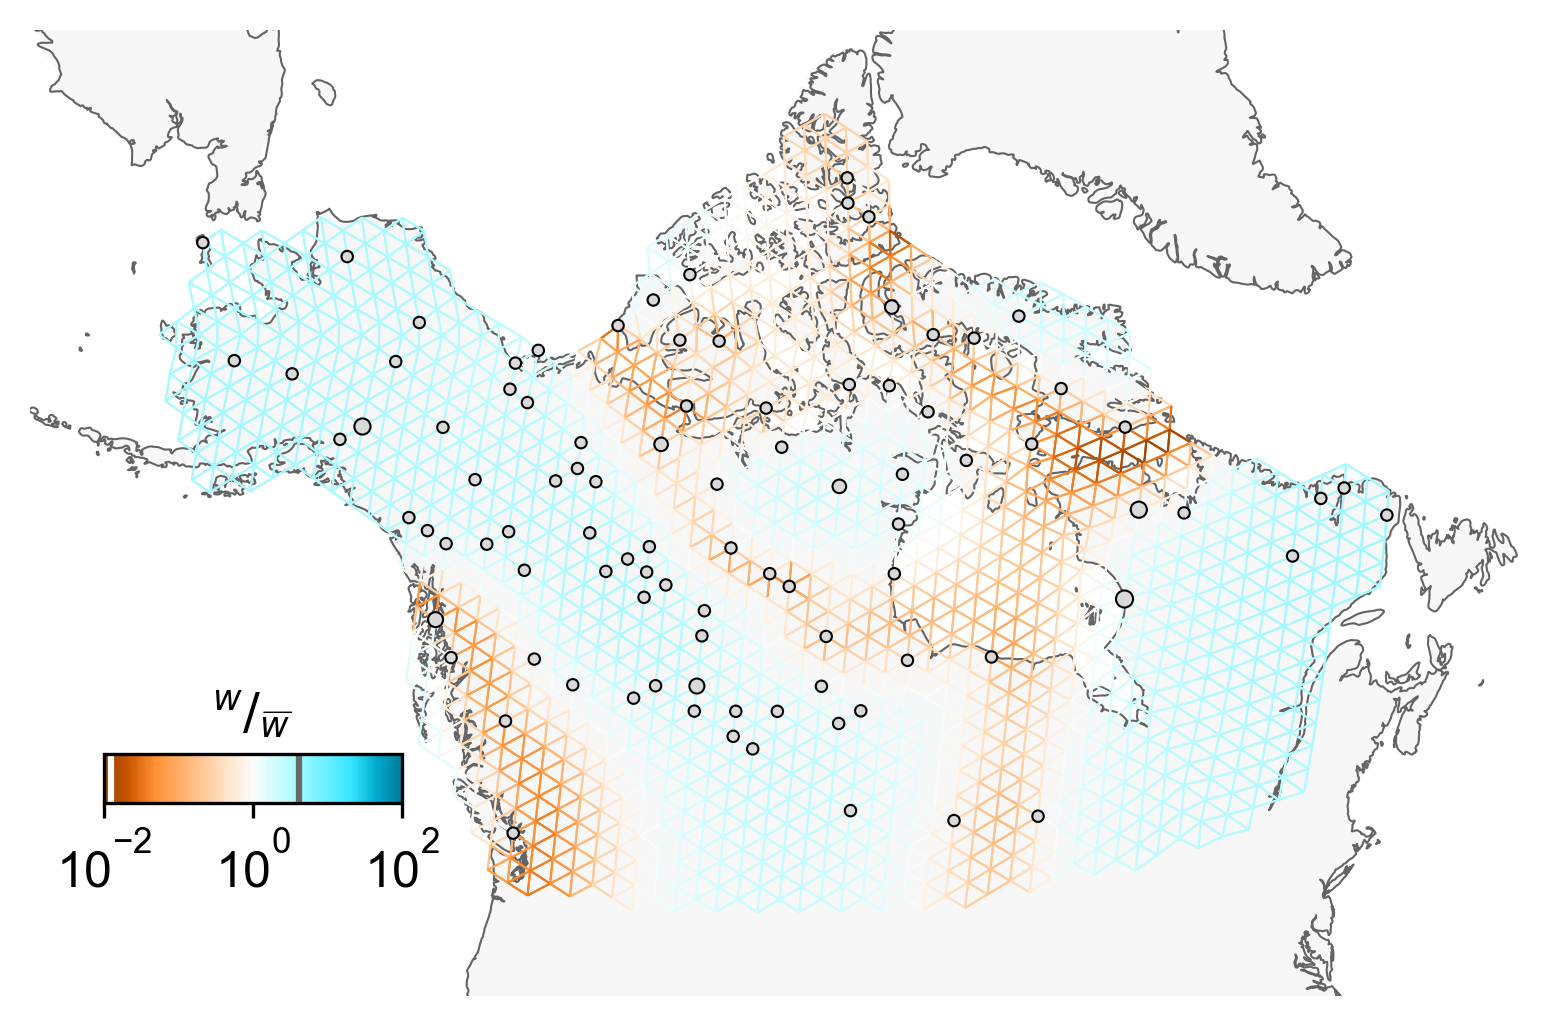

In [9]:
%%time
sp_graph.fit(lamb = 2.0, lamb_q = 10.0, optimize_q = 'n-dim')

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

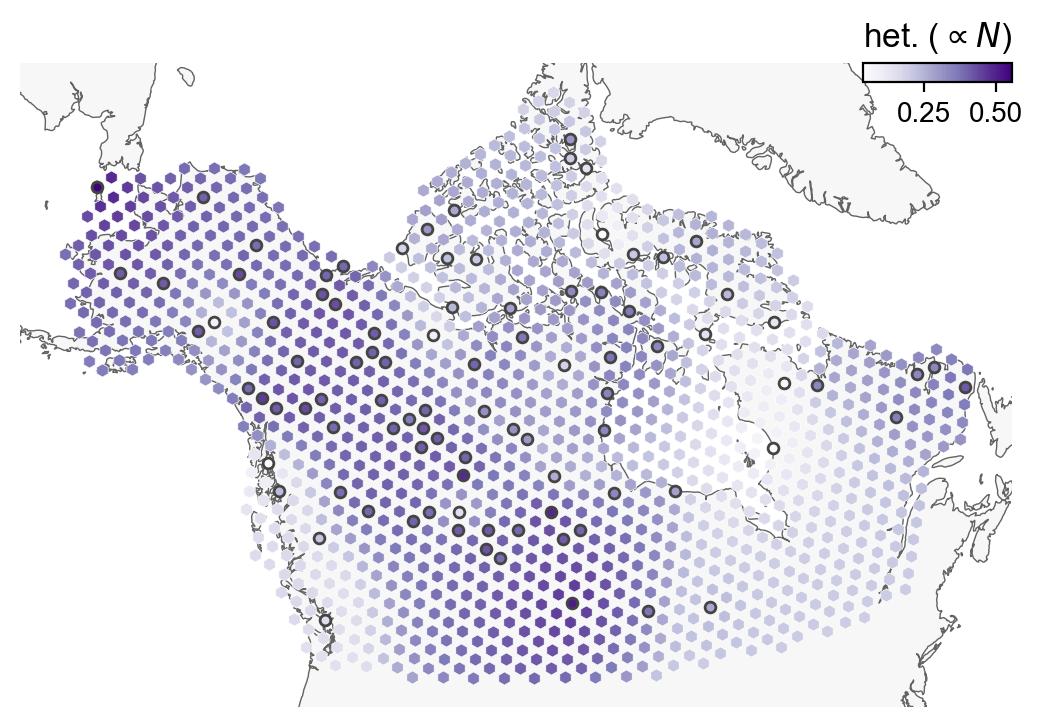

In [10]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_het()

# Fit `FEEMSmix` 

We will now go through the workflow of fitting long-range gene flow events over this baseline estimated migration surface found by `FEEMS`. This methodology is very similar to the idea of adding edges to an underlying topology in `TreeMix` (Pickrell & Pritchard 2012). 

Please refer to the preprint (https://doi.org/10.1101/2025.02.10.637386) for a more detailed explanation of the methods. 
There are three modes in which this can be run. There will be a fair bit of overlap in the results amongst the approaches, so we recommend users to choose what is best for their data:

1. (recommended approach) detect outliers on a baseline fit -> model largest outlier on the baseline graph -> find outliers on this new graph (baseline + long-range edge) -> repeat for a user-specified $K$ edges 
2. detect outliers on the baseline fit -> model each outlier _independently_ -> repeat until cycled through all outliers 
3. model long-range gene flow to any user-specified deme 

Outliers are chosen as the demes showing the largest negative residuals under the baseline fit. 

With all three modes, we employ a two-stage approach to finding the MLE location of the source and the admixture proportion. In the *first* stage, we separately fit an admixture proportion from `all` nodes (or some user-specified set of nodes) to a particular destination deme (assuming fixed weights and variances). In the *second* stage, we take the `top` (percent or number) nodes from the *first* stage (based on the log-likelihood) and refit the admixture proportions in a _joint_ manner with the weights and variances. This *second* stage is a costly procedure so we don't employ it on _all_ the nodes in the graph, however, we've found equivalent results with both schemes in the simulation (so we let users decide the value for `top`, default: $5\%$ or $0.05$).  

In this notebook, we run modes 2 and 3 (refer to _getting-started.ipynb_ for the recommended approach).

### Detecting outliers on baseline graph

We start by picking the top $1\%$ of pairs as putative outliers. We are not too concerned with a higher fraction as we've noticed that, typically, in the presence of false positives, the estimated admixture proportions tend to be small (see example at the very end of this notebook for deme _445_). 

In [7]:
# choose a specified level 
outliers_df = sp_graph.extract_outliers(fraction_of_pairs=0.01)

Using a top fraction of 0.01: 
  Putative recipient demes: [980 207 180 189 402 585 621 747 815]


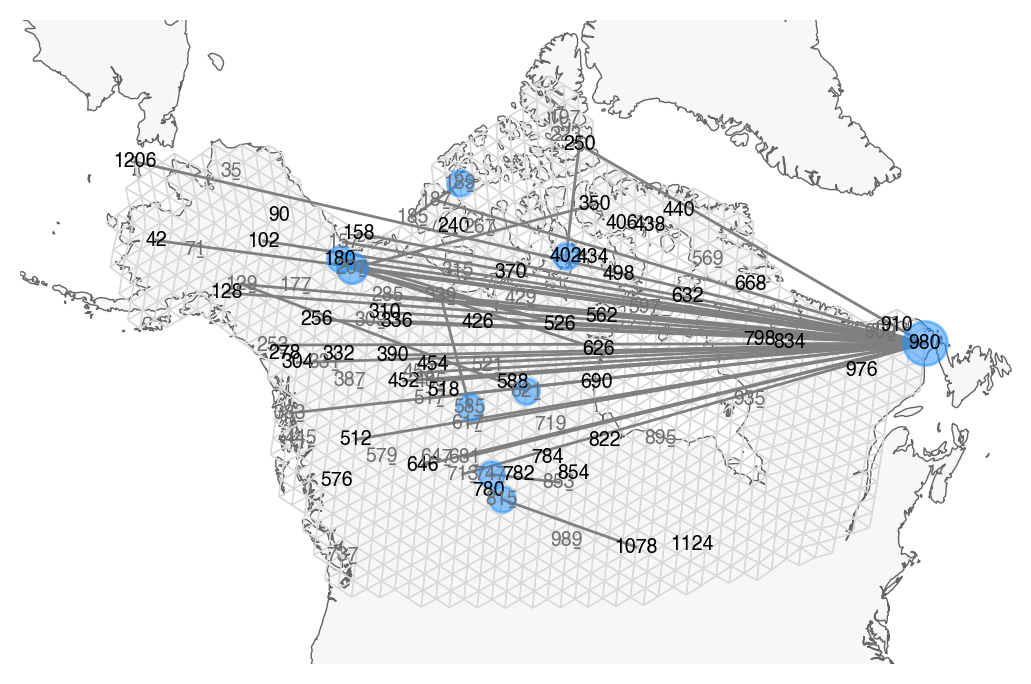

In [8]:
# visualizing the outlier demes on the map
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); v.draw_edges(use_weights=False)
# ~NEW~ function
v.draw_outliers(outliers_df)
# using deme IDs since all results will be represented with these numbers
v.draw_obs_nodes(use_ids=True)

#### Outliers with a different baseline fit

The identity of the outliers will change with different values of `lamb` and `lamb_q`, though there will be some overlap across this spectrum. We urge users to investigate this behavior, but as a starting point, we recommend users to start with the cross-validated values as chosen by the procedure in [cross-validation.ipynb](https://github.com/NovembreLab/feems/blob/main/docsrc/notebooks/cross-validation.ipynb).

Here, we show the outliers with a different value of `lamb=20` and `lamb_q=0.01`.  We see that some outlier demes (_980, 621, 207, 180, 1206_) persist with the newer fit, but we also observe some newer demes (_668, 315, 350_) pop up. 

Using a top fraction of 0.01: 
 source  dest.          source (lat., long.)           dest. (lat., long.)  scaled diff.
    383    737            (49.185, -123.584)            (57.154, -133.517)     -0.325945
    445    737            (49.185, -123.584)            (55.842, -131.309)     -0.229157
    129    980  (52.033, -57.21300000000002)            (63.082, -147.234)     -0.225809
    180    980  (52.033, -57.21300000000002)            (67.741, -135.602)     -0.218403
   1206    980            (63.532, -171.099)  (52.033, -57.21300000000002)     -0.210556
    207    980  (52.033, -57.21300000000002)            (67.509, -133.129)     -0.197461
    339    980  (52.033, -57.21300000000002)            (67.248, -117.054)     -0.196189
    129    621 (61.088, -103.71100000000001)            (63.082, -147.234)     -0.195993
   1078    815             (49.712, -93.839)   (54.0, -107.37099999999998)     -0.181069
    158    980  (52.033, -57.21300000000002)            (69.805, -134.399)     

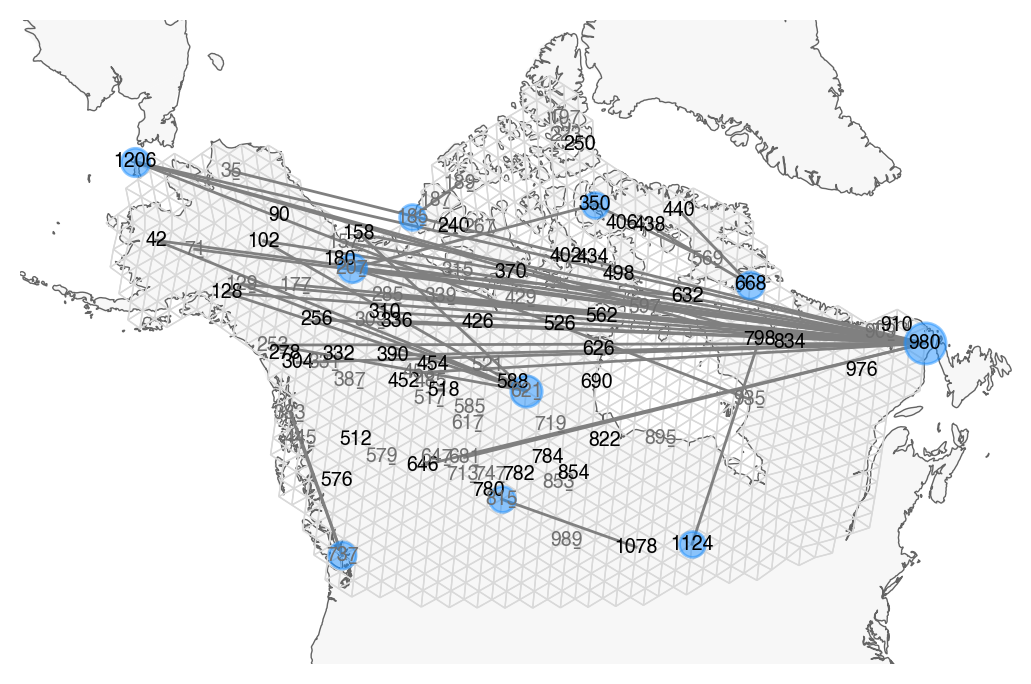

In [17]:
sp_graph.fit(lamb = 20.0, lamb_q = 0.01, optimize_q = 'n-dim')

# etract outliers 
outliers_df = sp_graph.extract_outliers(fraction_of_pairs=0.01, verbose=True)

# visualizing the outlier demes on the map
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); v.draw_edges(use_weights=False)
v.draw_outliers(outliers_df)
v.draw_obs_nodes(use_ids=True)

## Option 2 (`independent_fit`)

Another mode in which `FEEMSmix` can be run is via an independent fitting procedure. Here, all putative recipient demes found from the inital outliers list are fit separately. 

We also highlight two different mechanisms for choosing the source demes of the long-range gene flow event:

- 'all': fit `FEEMSmix` over all demes in the graph (default)
- 'radius': fit `FEEMSmix` over all demes with a certain radius of a sampled source deme chosen from the outlier detection method above

We also allow the user to exclude boundary nodes in the fitting procedure as we've noticed a few anomalies with estimates from these nodes in simulations. 

In [9]:
# resetting the LREs from the previous fit
sp_graph.edge = []; sp_graph.c = []
# refitting with the LOO-CV lambda parameters for baseline fit
sp_graph.fit(lamb=2., lamb_q=10., optimize_q='n-dim')
    
ind_results = sp_graph.independent_fit(
    outliers_df, 
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    nedges=3, top=5, 
    exclude_boundary=False, # exclude boundary nodes in fitting procedure
) 

Log-likelihood of initial fit: 7855.7


Fitting long-range edge to deme 980:
  Optimizing likelihood over 1202 demes in the graph...25%...50%...75%...done!
	Optimizing joint likelihood over 5/5 most likely demes in the graph...done!

  MLE edge found from source 743 to destination 980 with strength 0.41
  Log-likelihood after fitting deme 980: 8228.5

Fitting long-range edge to deme 207:
  Optimizing likelihood over 1200 demes in the graph...25%...50%...75%...done!
	Optimizing joint likelihood over 5/5 most likely demes in the graph...done!

  MLE edge found from source 368 to destination 207 with strength 0.73
  Log-likelihood after fitting deme 207: 8331.0

Fitting long-range edge to deme 180:
  Optimizing likelihood over 1200 demes in the graph...25%...50%...75%...done!
	Optimizing joint likelihood over 5/5 most likely demes in the graph...done!

  MLE edge found from source 753 to destination 180 with strength 0.75
  Log-likelihood after fitting deme 180: 8242.6
Exiting independent

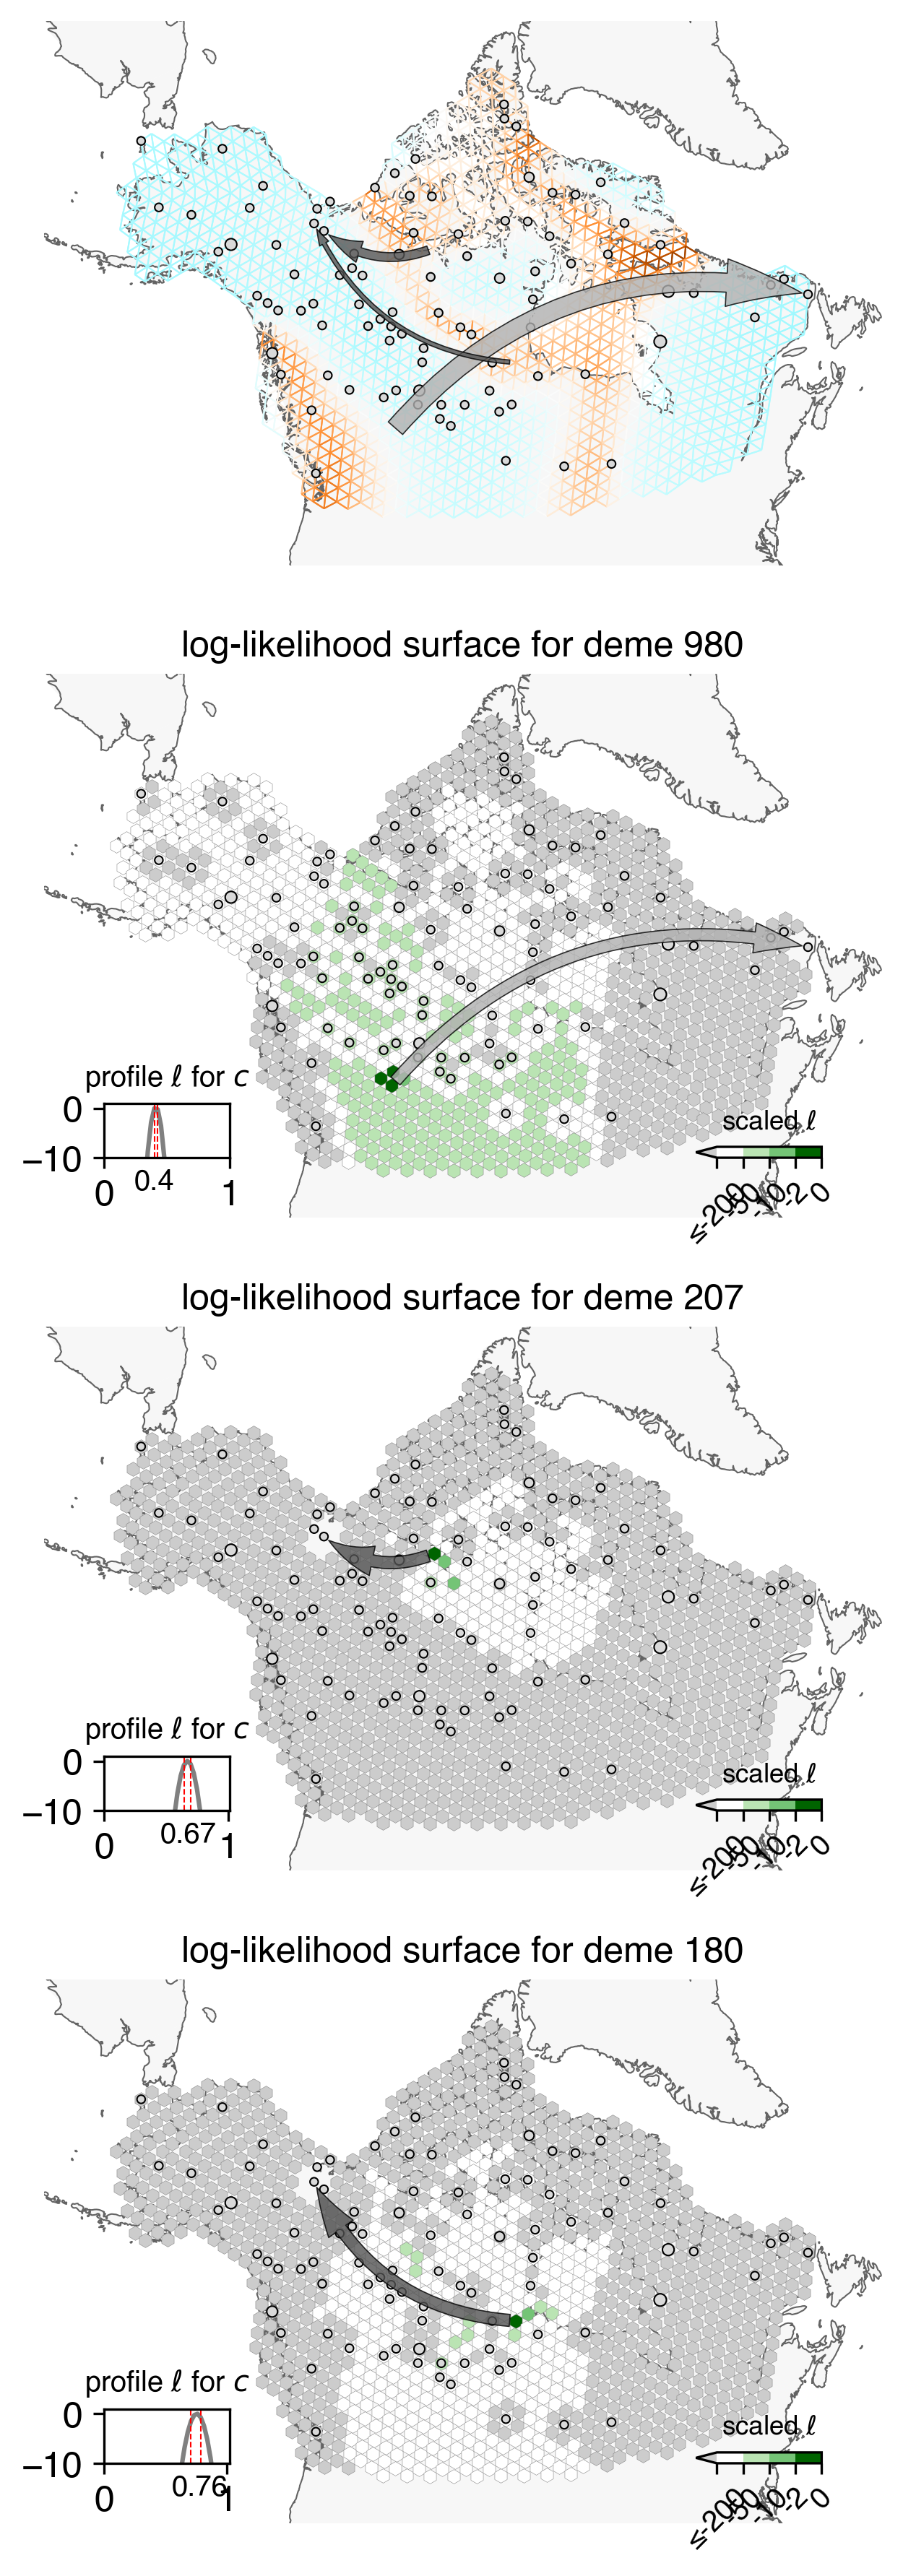

In [17]:
draw_FEEMSmix_surface(
    v, # Viz object created previously
    ind_results, # results from independet_fit above
    figsize=(8,15)
)

# (optional) save figure in a certain location
# plt.savefig('~/Desktop/wolvesadmix_independent_fit.pdf')

We see that adding a LRE to the baseline model improves the model fit by varying percentage points. 

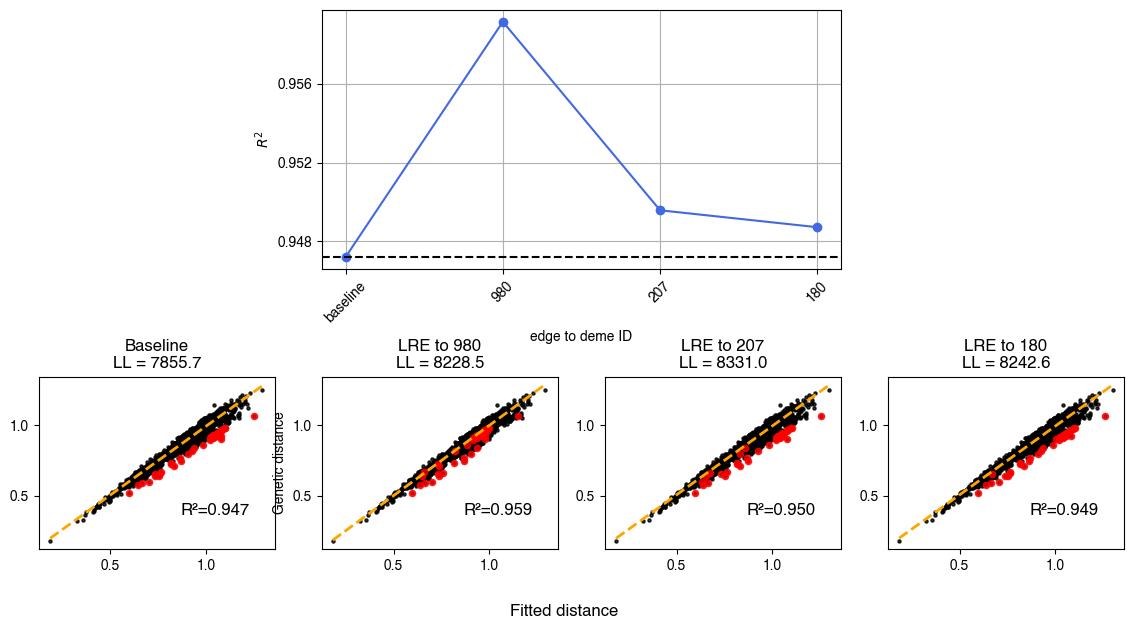

In [13]:
plot_FEEMSmix_summary(ind_results, sequential=False)

## Option 3 (pick a particular deme)

We provide this option for flexibility in modeling. Technically, `FEEMSmix` can fit a long-range admixture event to any sampled deme in the grid. There may be cases when the outlier detection scheme might not pick _true_ events in the data, but prior knowledge of the samples might suggest otherwise, so you might want to fit a LRE to this deme. 

To show the robustness of the model, we pick two demes that are _not_ implicated by the outlier detection method: deme _976_ and _445_, to demonstrate the performance of the model under a scenario with no known long-range gene flow. Refer to the map above for the location of the two demes. 

In [18]:
# first stage
df976 = sp_graph.calc_surface(
    destid=976,
)
# second stage
joint_df976 = sp_graph.calc_joint_surface(
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    surface_df=df976, 
    top=0.01,
    exclude_boundary=True
)

  Optimizing likelihood over 1040 demes in the graph...25%...50%...75%...done!
	Optimizing joint likelihood over 11/11 most likely demes in the graph...done!


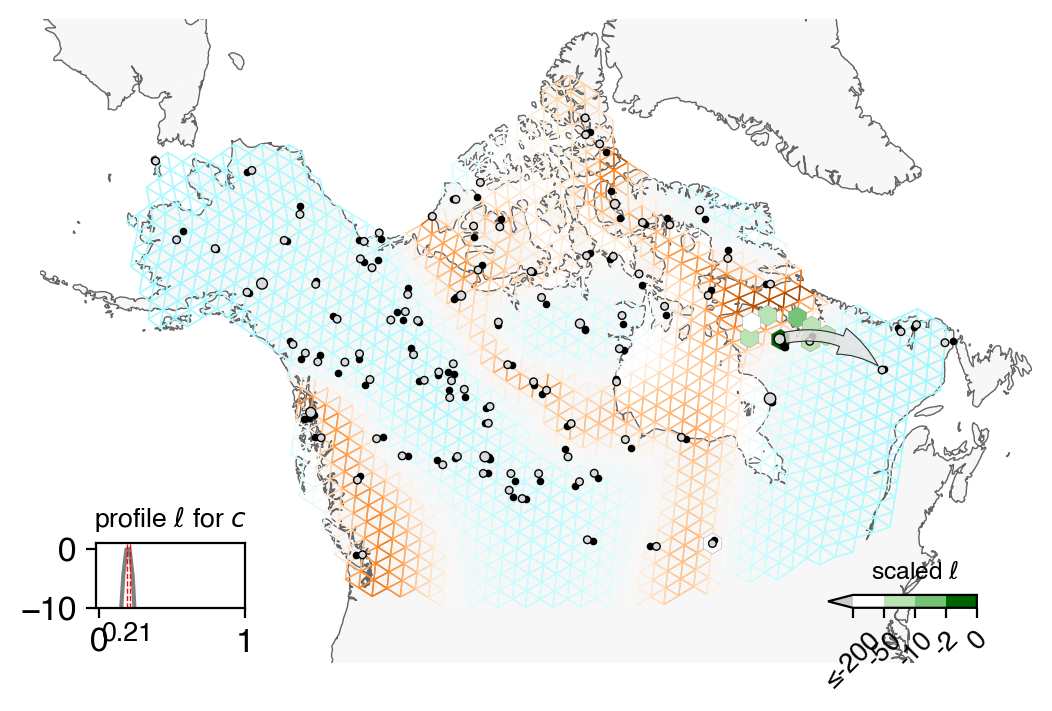

In [19]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_map(); 
# drawing the contour for deme 976
v.draw_loglik_surface(joint_df976) 
v.draw_samples(); v.draw_obs_nodes(use_ids=False)

For deme _976_, we see that the `FEEMSmix` estimates a "long-range" gene flow event with $\hat c \approx 0.2$. But, visually, we see that the source for this event is quite close to the putative destination deme _and_ lies within the same migration corridor as the sample in deme _976_, so this probably isn't a "true" long-range gene flow event. This could also be verified via other `admixture`-like analyses. 

Similarly, we can run the same analysis for deme _445_ in British Columbia.

In [20]:
# reset the counter & refit the surface when you fit a new LRE
sp_graph.edge = []; sp_graph.c = []
sp_graph.fit(lamb=2., lamb_q=10., optimize_q='n-dim')

# similarly, with deme 445
df445 = sp_graph.calc_surface(
    destid=445,
)
joint_df445 = sp_graph.calc_joint_surface(
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    surface_df=df445, 
    top=5, 
    exclude_boundary=False,
)

  Optimizing likelihood over 1040 demes in the graph...25%...50%...75%...done!
	Optimizing joint likelihood over 10/10 most likely demes in the graph...done!


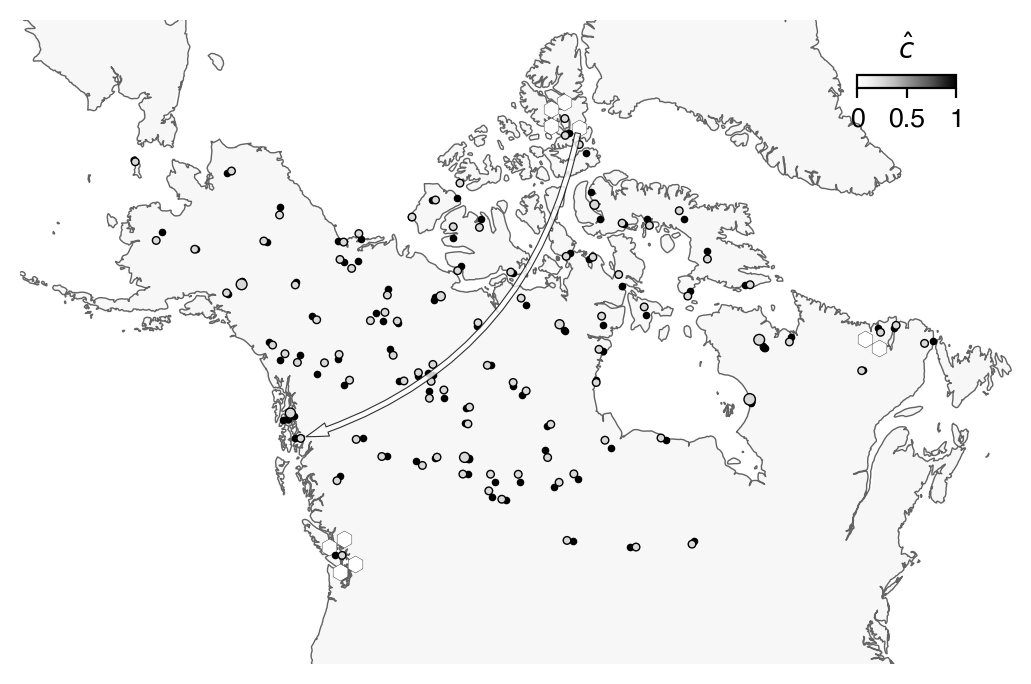

In [21]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); 
# visual trick to keep edges transparent 
v.edge_alpha=0; v.draw_edges(use_weights=False)
# drawing the surface for c values for deme 445 (and only for demes within 10 log-lik units of the MLE)
v.draw_c_surface(joint_df445, levels=-10)
v.draw_samples(); v.draw_obs_nodes(use_ids=False)

Here, we observe a similar signal with a low source fraction value to the previous run. Notice that this time we plotted a surface with hexagons that were colored by the value of the "source fraction" $\hat c$ instead of the log-likelihood (as previously done in green). 
Deme _445_ draws $\hat c \approx 0$ from a source in northern Canada (which is the MLE), but also shows zero admixture from every other source within $10$ log-likelihood units of the MLE (the visble hexagons). This indicates that the inferred LRE is probably an artifact of fitting an edge to a sample with no long-range genetic similarity. 

Happy fitting!